Inputs : 
 - 2- or 3- channel 3D image (widefield + deonvolution)
 - 

Assumptions :
 - if you use the filter_by_size flag, spots are assumed to be of similar size

Parameters :
 - approximate XY radius of a cell
 - approximate Z height of a cell
 - approximate size of a spot

The pieces I need are:
 - DoG
 - Thresholding (Otsu and Triangle)
 - MIP
 - Labeling
 - region statistics
 


In [70]:
#!groovy
#@ImageJ ij

image = ij.io().open("example_data/test1.tif")
w = image.dimension(0)
h = image.dimension(1)
ch = image.dimension(2)
d = image.dimension(3)

[w,h,ch,d]

497
183
3
56


Some utility functions

In [92]:
#!python
from net.imglib2 import FinalInterval

getZSliceXYZ = lambda im,z : ij.op().run("crop", im,
                                     FinalInterval.createMinSize(
                                         0, 0, z,
                                         im.dimension(0), im.dimension(1), 1), True)

In [93]:
getMid = lambda im : getZSliceXYZ(im,im.dimension(2)//2)

Crop each channel separately into `ch1` `ch2` and `nuc`.

In [94]:
ch1, ch2, nuc = [ ij.op().run("crop", image, FinalInterval.createMinSize(0,0,i,0,w,h,1,d), True) for i in range(3) ]

In [95]:
[ getMid(a) for a in [nuc,ch1,ch2] ]

<img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAfEAAAC3CAYAAAACRGe4AABz7UlEQVR42u2dV49s3VW1yTnnnHPOOWecscEBGweCDTbZGAO2wDbYYJvMK5ARIgghcYMEXHDDPRdIiL/BD+C+Pj0lPdZgfmvtUF19uqp6Hmmp+1RX7dpVe+011hxzzDHf4z3f8z0Pdx3v8R7vcRz5/z3P9f/5c3QMH18ae57bo0ePHnUNWnp8bT2rx+i1qMe9DybZe73Xe20C6i2gPHrNaJLPjjED5K03R4N4jx49zgXqszVots7cZe3ptavHySC+NdIeRcxbIu7ZjbElMt97nB49evS4jwh9DxvYa1WPiwfxpQh8K5W+JSpfO5e+OXr06HHu6Ps+IuQtwUuPHvcC4ucea9T8lr83iPfo0eM+QXwP6G5J9/U61ePqQXyNhl+L7s+Zf+rRo0ePtcBgjTVcSgH26PFExhZR213V6nsi8S3g3aNHjx5PQsx2Dhq817AeVxeJnytf3iDeo0ePSwHxvam+/j57PBiI74nO90TVe6LzziH16NHj0uvJe33q8ehy4lsU5y0E6dGjx62ZxvTo8aAgvpce31NiNnusR48ePS4BgHtt6tGReNdH9ujR48pqxPc+Z8llskePewNxcuCOh6ob79GjR49LKi87FcSbXu/x6EC8J3nnAXvR63GJIL53fWrRW48HqRO/T/A+R51lj6Y0e/R4qA3pqfOx53GPBwHxuwL6VlqqR48ePXoT2qPHGUH8rlH5ViOEHj169OjRo8cZQfw+afX+opuWbBqyR2s2evS4IhDvL7dH05A9rn0zuactac/fh68eeLQgflcqvRfjHg3iPW4VMPr7uCzwbjCfgHhH3D1ujfbs0eM+N5i9Bl4GiD/663BXOr0nWY8G9h63Ctq91jWQN4j36NEg3qNHjzMA+N4Om48OxPeWkvUE69G58h49ejzJKPzUVtmPok68wbtHg3iPHj1uBcQfRWS+F8R79HgStHnPud5s9ehxV0r9UWDYVhDvidTjWoRI/Z30Nehx2yDeGq4dIN4TqMe1RfD9nTxcPXWvGz2eFKXeIN4g3uMGFOpbOua1Ur/p/B63D+JbIvSbBfGm0Xtce+3uLc7dvv969NheK17LpZdAvUG8R48nGFUt9Xdean97axTvuT5D39c9bhHMl0D8poG8qfQel55nXXp8Fo03xdqjx+ME8fd+7/d+91gD85v4ThrAe1wbiO+5ua8lZ/qQ59f3fI9bAvIK4hXMbw7rGsR7XBOorT2+JYq/xPnd7EGPHncH8hqNPwpavYG7x7WA+FaAntUsX8Nc7w11jx53V61nNP6oIvGeFD2uAczWVOlbc+qXaE6ylg4497n2fd/jVtaKGnFvBfGrvwcawHtcuhJ7pjafKdNPidgvjU7f+5kaoHs0lf5/Afx93ud9jmME5jcH4j0pelxTOdWevPhWcLyEjcqWc+r7tUcD97o6HfB+3/d93+NIIL/RaqyeHD1uoyZ6D4hfWp78rlF3U+g92uTl/4/CMxq/YTe3niQ9bvtmvxSwnrEHW2n0c32GBvEe1wzaawBeQXxLTvzKgbwnTY/rjcb3AN6aE9ylL1hNufdo4F52aKsgviUf3pF4jx4PbECyBej2PHbfm5A9oru1SP1aSud69Fi7d7daps6eU8vK9gB4g3iPHvcchS+B7ClR+H3kmmeq+j0blq2fY2sNfY8e11AWlhH0mm3qFvBeOs4NejH0hOpxPaB+Kohvee2TSgPsYQe2iPNmn6MBvccl0+NVSf5+7/d+xzFSlY/AeCny3hON38D33ROux3Xmx7dQ0Fui13NF51usYveUvd21XrxBvMclma+Mom7A+gM+4AMOH/iBH3gcH/RBH3T8+f7v//7HAahXkdqp42YboPSk63ELefO7OLetRfx7aPE9DMIp+fC9gN1A3uMhwLtG2EbWWb/N4wD2h3zIhxw+9EM/9PBhH/Zhhw//8A8//vzgD/7g4wDUAfkRoJ8C7A3iPXpcIX13ipL9VCC8S078IcrNevS4j/y2ETYgXMGYn0bfgPdHfdRHHT7mYz7mOD76oz/6OD7yIz/y3QNg5xi8ptLte4G86fQePS605Oy+AHxvqdspSvUtrEJH2T2uRZwGwALWADdRtUBMxF0Hj3/sx37s4RM/8ROP45M+6ZMOn/zJn/zun4xP+IRPOAI7x3IzUKP7LWB+wz3FezL2uF1q/VQQ37tbv8sGYY+A7T4U9T163CXfXXPcADiRswDO+IiP+IgjYDP43f/zE4AGqAHsT//0Tz985md+5uFzP/dzD1/4hV94HJ/zOZ9z/BuROs8H/M2bG5XX6HwPiLc6vUePC60r39ogZUnZvSUKvivd3fXfPa7lHhtZmmaOmygZAAdsAV2ibOjyBHJ++n9//7iP+7hjJP5pn/Zph8/+7M8+fNEXfdHha7/2aw/f8A3fcPjyL//yI7ATnX/8x3/88XjQ8ETlCuDMmY+o9uqd3iDeo8cNOD6dIiw79f1OOf+OtntcIoCbz7YczGGuG2AFqAFlAJefRNoJ5AK3jzEAfKLxT/mUTzmC+Jd+6ZceAfwbv/EbD1/5lV95+LzP+7wjwPN3nsdrBHKV7ebcBfSk3G9cpd4TtMfjAvG9FPverml7j7FWQtfXt8dD31uAHqBoLjsBUwAHSInCAVgAnEEkLog7BHBFbAzz4gA19PmXfMmXHL7qq77qGIUTlQPsn/EZn3H8O8/j9dD1ADnno5pdEZ2gPgLyG4zGe5L2eBwAftfnn6vE7RSFeoN7j4cEcKNwQdyctJF5grh5btXmRtsJ2lLtDKN26HLpdCLvL/iCLzgO8uOf9VmfdcyXG4nz+qpgdwjuVdG+1s2sQbxHjysA8b0R+ym0+CkK8s5/97hkAAcErekGHI10E8AFcUA0aXN/JrBXEAfAP/VTP/UYbZP/BrAVuTF4nP/zHICcaJzXeYzcHPA4g/cVyKvo7cYo9Z6sPW4LyLeKxc7VNexcZV9LNeYN7j0eCsABPo1ZoKod6bJmPTgjjVsEcPPeAK414QIwUTjqc6Jwh2DtT38HyInKpdf9m+Vo/A4dTyQP0HMenOOWaLxBvEePKxW5bY3It4DrfSwGHaX3eNLgXQEc6lzABqh1WXNk7fcIxDNKFsgFcKJwwDcBPAd/z0gdiv0rvuIrjoI3S9CI1nktfyeH/sVf/MXHY2Y0ruPbDVLqPXF7NIDfJRo/VyvTBukelxZ9C95S5YI0wCwIW0ZmPtohiCtiy+g71ehS5wncALK0Os/R/IXHP//zP/8oevu6r/u6I5jzf6JzKXdAncFrFMCx+RiB+I0AeU/eHrfj5nZu6nyvPetdFoKOtntcQg24hi2WjNUIG2AmogZkiXgRngG0ADXAnZE4o6rRBXNAFuAVgJM65zGibGhxgFmqXHAHuFGw8/5Q624EkpLnNWwyeE/OX3OYGwTynsA9bgvI95i9nNvFbatDW1+vHpcyADGArZaKAXyCdqXHiaKhtanjJiIGbAFM/i7F7mtSmS6YK2YDvImaVZ8DvvzU8AUg53dpdp8j+APoCf7mxn0+78GGgfOplPoNAXlP4h63LXI7B5CvlaA1bd7jWu8VQC27iY1o8DRr0WENECUv/TVf8zXHaDxBPDcA1oEniFsXnhG3EbngDHj7WArbknZP4M6RKnYd3tKq9cYMYHoi92jzlyfZNaxBvMclUegAG6ArcAOwepkb4UpLJzXOY4Ku3ubS6UbiKWpLoxf+X0HccjJz4Tq0cWyem+djk5RsmlLV7Nk8pXZCG/mrN4j36PHIRG57wHlN/NbA3uMhaHTrvwFcgDUNV4iuHTwGaKfJihG1QrUUt9Xysmq5KohLnUunp8hN8AaIGQK2Hc/yMaNv6XiHdHratGbd+I1E4z2ZezSI39X8ZU9L086L97iUKJyoFGADXAFFgA/QRjSG5Snq7y/7si87Aq2ACFin/3ntB57

## Difference of Gaussians


In [84]:
#!python

vars={
    "input": ch1,
    "sigmaBig": [3,3,1],
    "sigmaSmall": [1,1,0.5]
}

output = ij.op().eval("gauss(input, sigmaBig)-gauss(input,sigmaSmall)", vars)

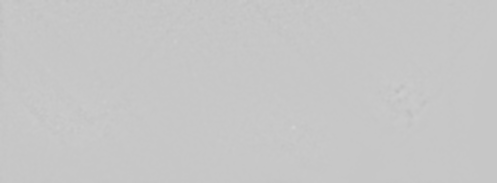

In [85]:
output

## Thresholding (Otsu and Triangle)

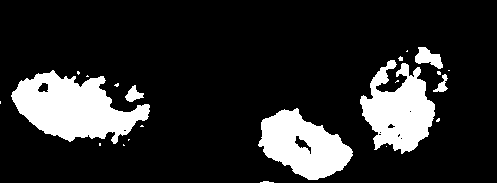

In [96]:
ij.op().threshold().otsu(getMid(nuc))

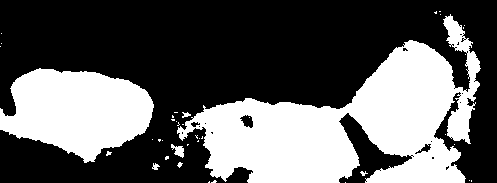

In [97]:
ij.op().threshold().triangle(getMid(ch1))

In [103]:
ij.op().threshold().triangle(ij.op().image().histogram(ch1))

1329​.8680419921875

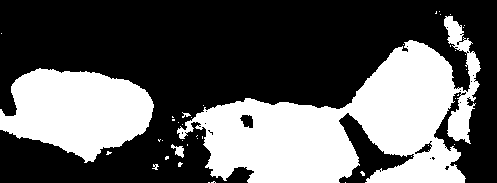

In [101]:
getMid(ij.op().threshold().triangle(ch1))

## Maximum Intensity Projection

## Thresholding (Otsu and Triangle)

## Region Statistics